In [2]:
import random

import imageio
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt

# function to display the topdown map
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

In [1]:

# mp3d
#test_scene_dir = "/home/azureuser/data/scene_datasets/mp3d"
#test_scene = f"{test_scene_dir}/17DRP5sb8fy/17DRP5sb8fy.glb"
#mp3d_scene_dataset = f"{test_scene_dir}/mp3d.scene_dataset_config.json"

# hm3d v2
test_scene_dir = "/datadrive/azure_storage/pactdata/habitat-data/habitat-dataset/hm3d"
test_scene = f"{test_scene_dir}/minival/00800-TEEsavR23oF/TEEsavR23oF.basis.glb"
mp3d_scene_dataset = f"{test_scene_dir}/hm3d_annotated_basis.scene_dataset_config.json"

rgb_sensor = True  # @param {type:"boolean"}
depth_sensor = True  # @param {type:"boolean"}
semantic_sensor = True  # @param {type:"boolean"}

sim_settings = {
    "width": 256,  # Spatial resolution of the observations
    "height": 256,
    "scene": test_scene,  # Scene path
    "scene_dataset": mp3d_scene_dataset,  # the scene dataset configuration files
    "default_agent": 0,
    "sensor_height": 1.5,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": 1,  # used in the random navigation
    "enable_physics": False,  # kinematics only
}


# %%
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.scene_dataset_config_file = settings["scene_dataset"]
    sim_cfg.enable_physics = settings["enable_physics"]

    # Note: all sensors must have the same resolution
    sensor_specs = []

    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(color_sensor_spec)

    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(depth_sensor_spec)

    semantic_sensor_spec = habitat_sim.CameraSensorSpec()
    semantic_sensor_spec.uuid = "semantic_sensor"
    semantic_sensor_spec.sensor_type = habitat_sim.SensorType.SEMANTIC
    semantic_sensor_spec.resolution = [settings["height"], settings["width"]]
    semantic_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    semantic_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(semantic_sensor_spec)

    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
    }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


# %%
cfg = make_cfg(sim_settings)
# Needed to handle out of order cell run in Colab
try:  # Got to make initialization idiot proof
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)






NameError: name 'habitat_sim' is not defined

In [8]:
# %%
def print_scene_recur(scene, limit_output=10):
    print(
        f"House has {len(scene.levels)} levels, {len(scene.regions)} regions and {len(scene.objects)} objects"
    )
    print(f"House center:{scene.aabb.center} dims:{scene.aabb.sizes}")

    count = 0
    for level in scene.levels:
        print(
            f"Level id:{level.id}, center:{level.aabb.center},"
            f" dims:{level.aabb.sizes}"
        )
        for region in level.regions:
            print(
                f"Region id:{region.id}, category:{region.category.name()},"
                f" center:{region.aabb.center}, dims:{region.aabb.sizes}"
            )
            for obj in region.objects:
                print(
                    f"Object id:{obj.id}, category:{obj.category.name()},"
                    f" center:{obj.aabb.center}, dims:{obj.aabb.sizes}"
                )
                count += 1
                if count >= limit_output:
                    return


# Print semantic annotation information (id, category, bounding box details)
# about levels, regions and objects in a hierarchical fashion
scene = sim.semantic_scene
print_scene_recur(scene)

House has 0 levels, 14 regions and 661 objects
House center:[0. 0. 0.] dims:[-inf -inf -inf]


In [9]:
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)


agent_state: position [-0.6  0.   0. ] rotation quaternion(1, 0, 0, 0)
action move_forward
hh


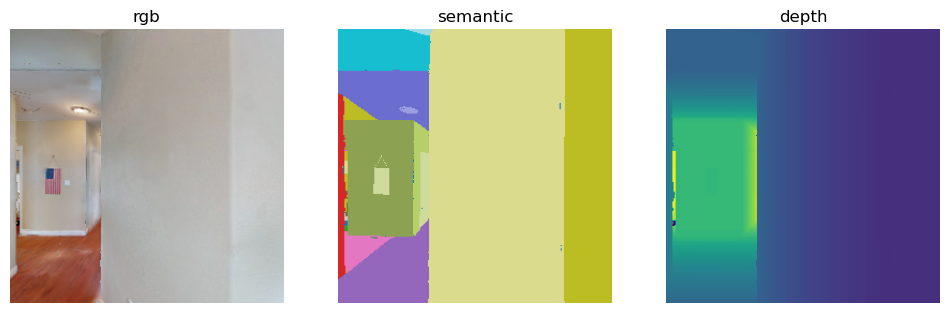

action turn_right
hh


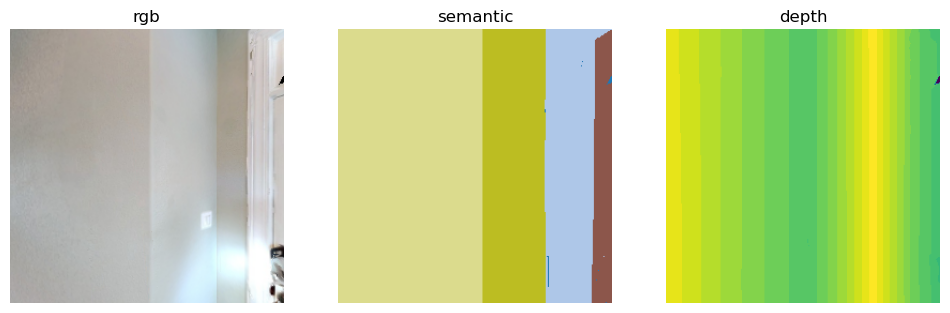

action move_forward
hh


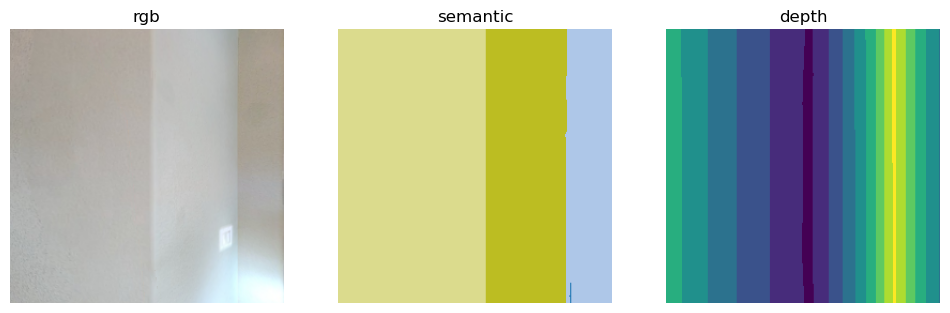

action turn_left
hh


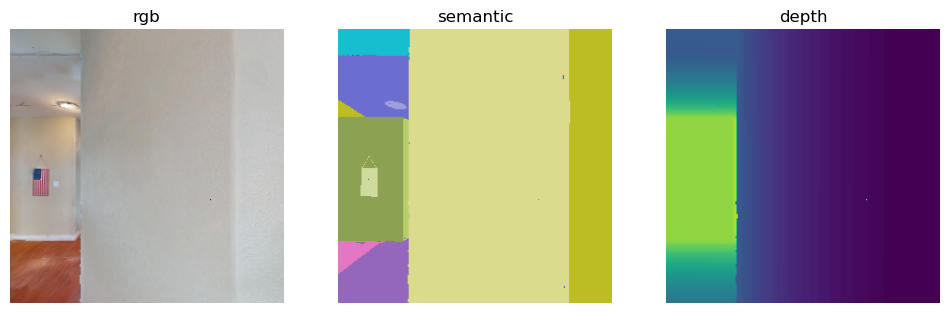

action move_forward
hh


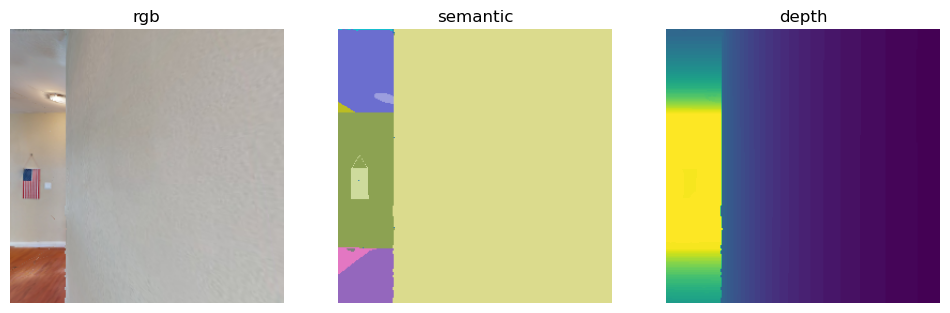

In [11]:
# %%
# the randomness is needed when choosing the actions
random.seed(sim_settings["seed"])
sim.seed(sim_settings["seed"])

# Set agent state
agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([-0.6, 0.0, 0.0])  # world space
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

# %%
total_frames = 0
action_names = list(cfg.agents[sim_settings["default_agent"]].action_space.keys())

max_frames = 5

while total_frames < max_frames:
    action = random.choice(action_names)
    print("action", action)
    observations = sim.step(action)
    rgb = observations["color_sensor"]
    semantic = observations["semantic_sensor"]
    depth = observations["depth_sensor"]

    if display:
        print("hh")
        display_sample(rgb, semantic, depth)

    total_frames += 1